In [203]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, asc, desc, when, isnull, create_map
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark_dist_explore import hist, distplot
from functools import reduce

import matplotlib.pyplot as plt
import pyspark
import glob

In [204]:
spark = SparkSession.builder.appName("spark-sql").config("spark.driver.memory", "32g").getOrCreate()

In [205]:
# load data
parquet_files = glob.glob('./data/*.parquet')

dfs = []
for f in parquet_files:
    dfs.append(spark.read.parquet(f))
    
df_raw = reduce(DataFrame.union, dfs)

df_raw.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Mar

In [206]:
# subset columns
cols = [
    "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "AirTime",
    "Distance",
    "ArrivalDelayGroups"
]

df = df_raw.select(*cols)

In [207]:
# create variable on_time
"""
on_time: (bool) if depdelaymin == 0 and arrdelaymin == 0 then true
"""
df = df.withColumn(
    "on_time",
    when(((col("ArrDelayMinutes") == 0.0) | (col("DepDelayMinutes") == 0.0)) & ~col("Cancelled"), True)
    .otherwise(False)
)

In [208]:
# create variable delay_group
"""
delay_group: (string) delaymin == 0, on time
                      delaymin > 0, delaymin <= 15, small delay
                      delaymin > 15, delaymin <= 45, medium delay
                      delaymin > 45, large  delay
                      otherwise cancelled
"""
df = df.withColumn(
    "delay_group",
    when(col("on_time"), "On Time")
    .when(((col("DepDelayMinutes") > 0) & (col("DepDelayMinutes") <= 15)) | ((col("ArrDelayMinutes") > 0) & (col("ArrDelayMinutes") <= 15)), "Small Delay")
    .when(((col("DepDelayMinutes") > 15) & (col("DepDelayMinutes") <= 45)) | ((col("ArrDelayMinutes") > 15) & (col("ArrDelayMinutes") <= 45)), "Medium Delay")
    .when((col("DepDelayMinutes") > 45) | (col("ArrDelayMinutes") > 45), "Large Delay")
    .otherwise("Cancelled")
)


In [209]:
# cast variable types long -> double
cols_long = [
    "Flight_Number_Marketing_Airline",        
    "CRSDepTime",
    "CRSArrTime"
]

for c in cols_long:
    df = df.withColumn(c, col(c).cast("double"))

df.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- CRSDepTime: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSArrTime: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrivalDelayGroups: double (nullable = true)
 |-- on_time: boolean (nullable = false)
 |-- delay_group: string (nullable = false)



In [210]:
# top 10 performers
df_airline = df.groupBy("Airline").count().withColumnRenamed("count", "total")
df_on_time = df.filter(col("delay_group") == "On Time").groupBy("Airline").count().withColumnRenamed("count", "on_time_count")

df_airline = df_airline \
    .join(df_on_time, "Airline") \
    .withColumn("pct", (col("on_time_count") / col("total")))

df_airline.orderBy(col("pct").desc()).show(10, truncate = False)

+---------------------------+-------+-------------+------------------+
|Airline                    |total  |on_time_count|pct               |
+---------------------------+-------+-------------+------------------+
|Cape Air                   |1661   |1413         |0.8506923540036123|
|Endeavor Air Inc.          |998224 |830582       |0.8320597380948564|
|Delta Air Lines Inc.       |3294917|2655921      |0.8060661315596114|
|Republic Airlines          |1283704|1025293      |0.7986989212466425|
|SkyWest Airlines Inc.      |3159683|2492446      |0.7888278665929462|
|Capital Cargo International|392011 |307136       |0.7834882184428498|
|Compass Airlines           |154985 |120306       |0.7762428622124722|
|Alaska Airlines Inc.       |906259 |700379       |0.7728243250549788|
|Horizon Air                |471153 |364045       |0.7726683264247495|
|Air Wisconsin Airlines Corp|380202 |293447       |0.7718186648150194|
+---------------------------+-------+-------------+------------------+
only s

In [211]:
# bottom 10 performers
df_airline.orderBy(col("pct").asc()).show(10, truncate = False)

+-----------------------------------------+-------+-------------+------------------+
|Airline                                  |total  |on_time_count|pct               |
+-----------------------------------------+-------+-------------+------------------+
|Peninsula Airways Inc.                   |2783   |1410         |0.5066475026949335|
|Allegiant Air                            |489400 |319988       |0.6538373518594197|
|JetBlue Airways                          |1106079|744112       |0.6727476066356924|
|Southwest Airlines Co.                   |5474339|3729079      |0.6811925604168833|
|Commutair Aka Champlain Enterprises, Inc.|260048 |178203       |0.6852696425275334|
|Frontier Airlines Inc.                   |570452 |393388       |0.6896075392846375|
|Empire Airlines Inc.                     |23122  |15978        |0.691030187700026 |
|Trans States Airlines                    |161590 |112895       |0.6986509066155084|
|American Airlines Inc.                   |3134117|2298008      |

In [212]:
# unique plane ID
df_plane = df.filter(~isnull(col("Tail_Number"))).groupBy("Tail_Number").count()
df_plane.orderBy(col("count").desc()).show(10)
df_plane.distinct().count()

+-----------+-----+
|Tail_Number|count|
+-----------+-----+
|     N480HA|12470|
|     N491HA|12376|
|     N494HA|12248|
|     N492HA|11985|
|     N487HA|11945|
|     N483HA|11935|
|     N493HA|11837|
|     N486HA|11797|
|     N476HA|11771|
|     N488HA|11727|
+-----------+-----+
only showing top 10 rows



7089

In [214]:
# linear regression

variables_d = [
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

variables_a = [
    "ArrDelayMinutes",
    "CRSArrTime",
    "ArrTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

predictors_d = [
    "DepDelayMinutes",
    "CRSDepTime",
    "DepTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

predictors_a = [
    "ArrDelayMinutes",
    "CRSArrTime",
    "ArrTime",
    "Distance",
    "Cancelled",
    "Diverted",
    "on_time"
]

df_lr_d = df.select(*variables_d).dropna()
df_lr_a = df.select(*variables_a).dropna()

In [104]:
# departure delay
# put predoctors into a vector column
assembler = VectorAssembler(inputCols = predictors_d, outputCol = "features")
assembled_df_d = assembler.transform(df_lr_d)

# assembled_df_d.show()

# subset features and response
df_analysis_d = assembled_df_d.select("features", "DepDelayMinutes")

# split data intro train and test
train_data_d, test_data_d = assembled_df_d.randomSplit([0.7, 0.3])

# build model
lr_d = LinearRegression(featuresCol = "features", labelCol = "DepDelayMinutes", predictionCol = "predDepDelay")

# fit data to model
mod_d = lr_d.fit(train_data_d)

In [215]:
# regression coefficients departure
d = [mod_d.intercept]
coeffs_d = mod_d.coefficients.toArray().tolist()

for elem in coeffs_d:
    d.append(elem)

vars_d = variables_d
vars_d[0] = "intercept"
vars_d

data_d = list(map(lambda x, y: (x, y), vars_d, d))
cols_d = ["variable", "coeffcient"]

coef_df_d = spark.createDataFrame(data_d, cols_d)
coef_df_d.show(truncate = False)

+----------+-----------------------+
|variable  |coeffcient             |
+----------+-----------------------+
|intercept |1.8615466531080166E-14 |
|CRSDepTime|0.9999999999999998     |
|DepTime   |1.3731461534976354E-16 |
|Distance  |-1.3500237264990898E-16|
|Cancelled |-2.5297577974580323E-18|
|Diverted  |3.04225978857149E-15   |
|on_time   |2.5038072472242403E-15 |
+----------+-----------------------+



In [216]:
# generate predictions departure
pred_results_d = mod_d.transform(test_data_d)
pred_results_d.select("DepDelayMinutes", "PredDepDelay").show(truncate = False)

+---------------+-----------------------+
|DepDelayMinutes|PredDepDelay           |
+---------------+-----------------------+
|0.0            |-4.2285136305267026E-15|
|0.0            |-3.2422036208527774E-13|
|0.0            |-3.2462536920322753E-13|
|0.0            |-3.2476037157587736E-13|
|0.0            |-3.248953739485273E-13 |
|0.0            |-3.248953739485273E-13 |
|0.0            |-3.2396534828844737E-13|
|0.0            |-3.250303763211772E-13 |
|0.0            |-3.259486784016545E-13 |
|0.0            |-3.2330094719710055E-13|
|0.0            |-3.2261630804337405E-13|
|0.0            |-3.2423535303374713E-13|
|0.0            |-3.2621868314695425E-13|
|0.0            |-3.254353834391269E-13 |
|0.0            |-3.3016348798038405E-13|
|0.0            |-3.3188878279825044E-13|
|0.0            |-3.3188878279825044E-13|
|0.0            |-5.7923389795509756E-15|
|0.0            |-3.2443144635169016E-13|
|0.0            |-3.2372292657008663E-13|
+---------------+-----------------

In [181]:
# arrival delay
# put predoctors into a vector column
assembler = VectorAssembler(inputCols = predictors_a, outputCol = "features")
assembled_df_a = assembler.transform(df_lr_a)

# assembled_df_a.show()

# subset features and response
df_analysis_a = assembled_df_a.select("features", "ArrDelayMinutes")

# split data intro train and test
train_data_a, test_data_a = assembled_df_a.randomSplit([0.7, 0.3])

# build model
lr_a = LinearRegression(featuresCol = "features", labelCol = "ArrDelayMinutes", predictionCol = "predArrDelay")

# fit data to model
mod_a = lr_a.fit(train_data_a)

In [217]:
# regression coefficients arrival
a = [mod_a.intercept]
coeffs_a = mod_a.coefficients.toArray().tolist()

for elem in coeffs_a:
    a.append(elem)

data_a = list(map(lambda x, y: (x, y), vars_d, a))

coef_df_a = spark.createDataFrame(data_a, cols_d)
coef_df_a.show(truncate = False)

+----------+----------------------+
|variable  |coeffcient            |
+----------+----------------------+
|intercept |7.259549593647617E-10 |
|CRSDepTime|0.9999999999759857    |
|DepTime   |-5.553436632540114E-11|
|Distance  |5.122693075695906E-11 |
|Cancelled |1.833084157464325E-12 |
|Diverted  |0.0                   |
|on_time   |0.0                   |
+----------+----------------------+



In [218]:
#print predicted results arrival
pred_results_a = mod_a.transform(test_data_a)
pred_results_a.select("ArrDelayMinutes", "predArrDelay").show(truncate = False)

+---------------+---------------------+
|ArrDelayMinutes|predArrDelay         |
+---------------+---------------------+
|0.0            |8.351832463592782E-9 |
|0.0            |8.560804057543716E-9 |
|0.0            |8.725781631715504E-9 |
|0.0            |8.725781631715504E-9 |
|0.0            |8.725781631715504E-9 |
|0.0            |8.881593785099972E-9 |
|0.0            |9.167554913664407E-9 |
|0.0            |9.229879775018195E-9 |
|0.0            |9.404022769977304E-9 |
|0.0            |9.724812497533562E-9 |
|0.0            |9.8256321261941E-9   |
|0.0            |9.8256321261941E-9   |
|0.0            |9.96128035384646E-9  |
|0.0            |9.96128035384646E-9  |
|0.0            |1.2974506226836798E-7|
|0.0            |1.3139097299046685E-7|
|0.0            |1.3139097299046685E-7|
|0.0            |1.3144219992122382E-7|
|0.0            |1.314934268519808E-7 |
|0.0            |1.293321212046783E-7 |
+---------------+---------------------+
only showing top 20 rows



(0.0, 3000.0)

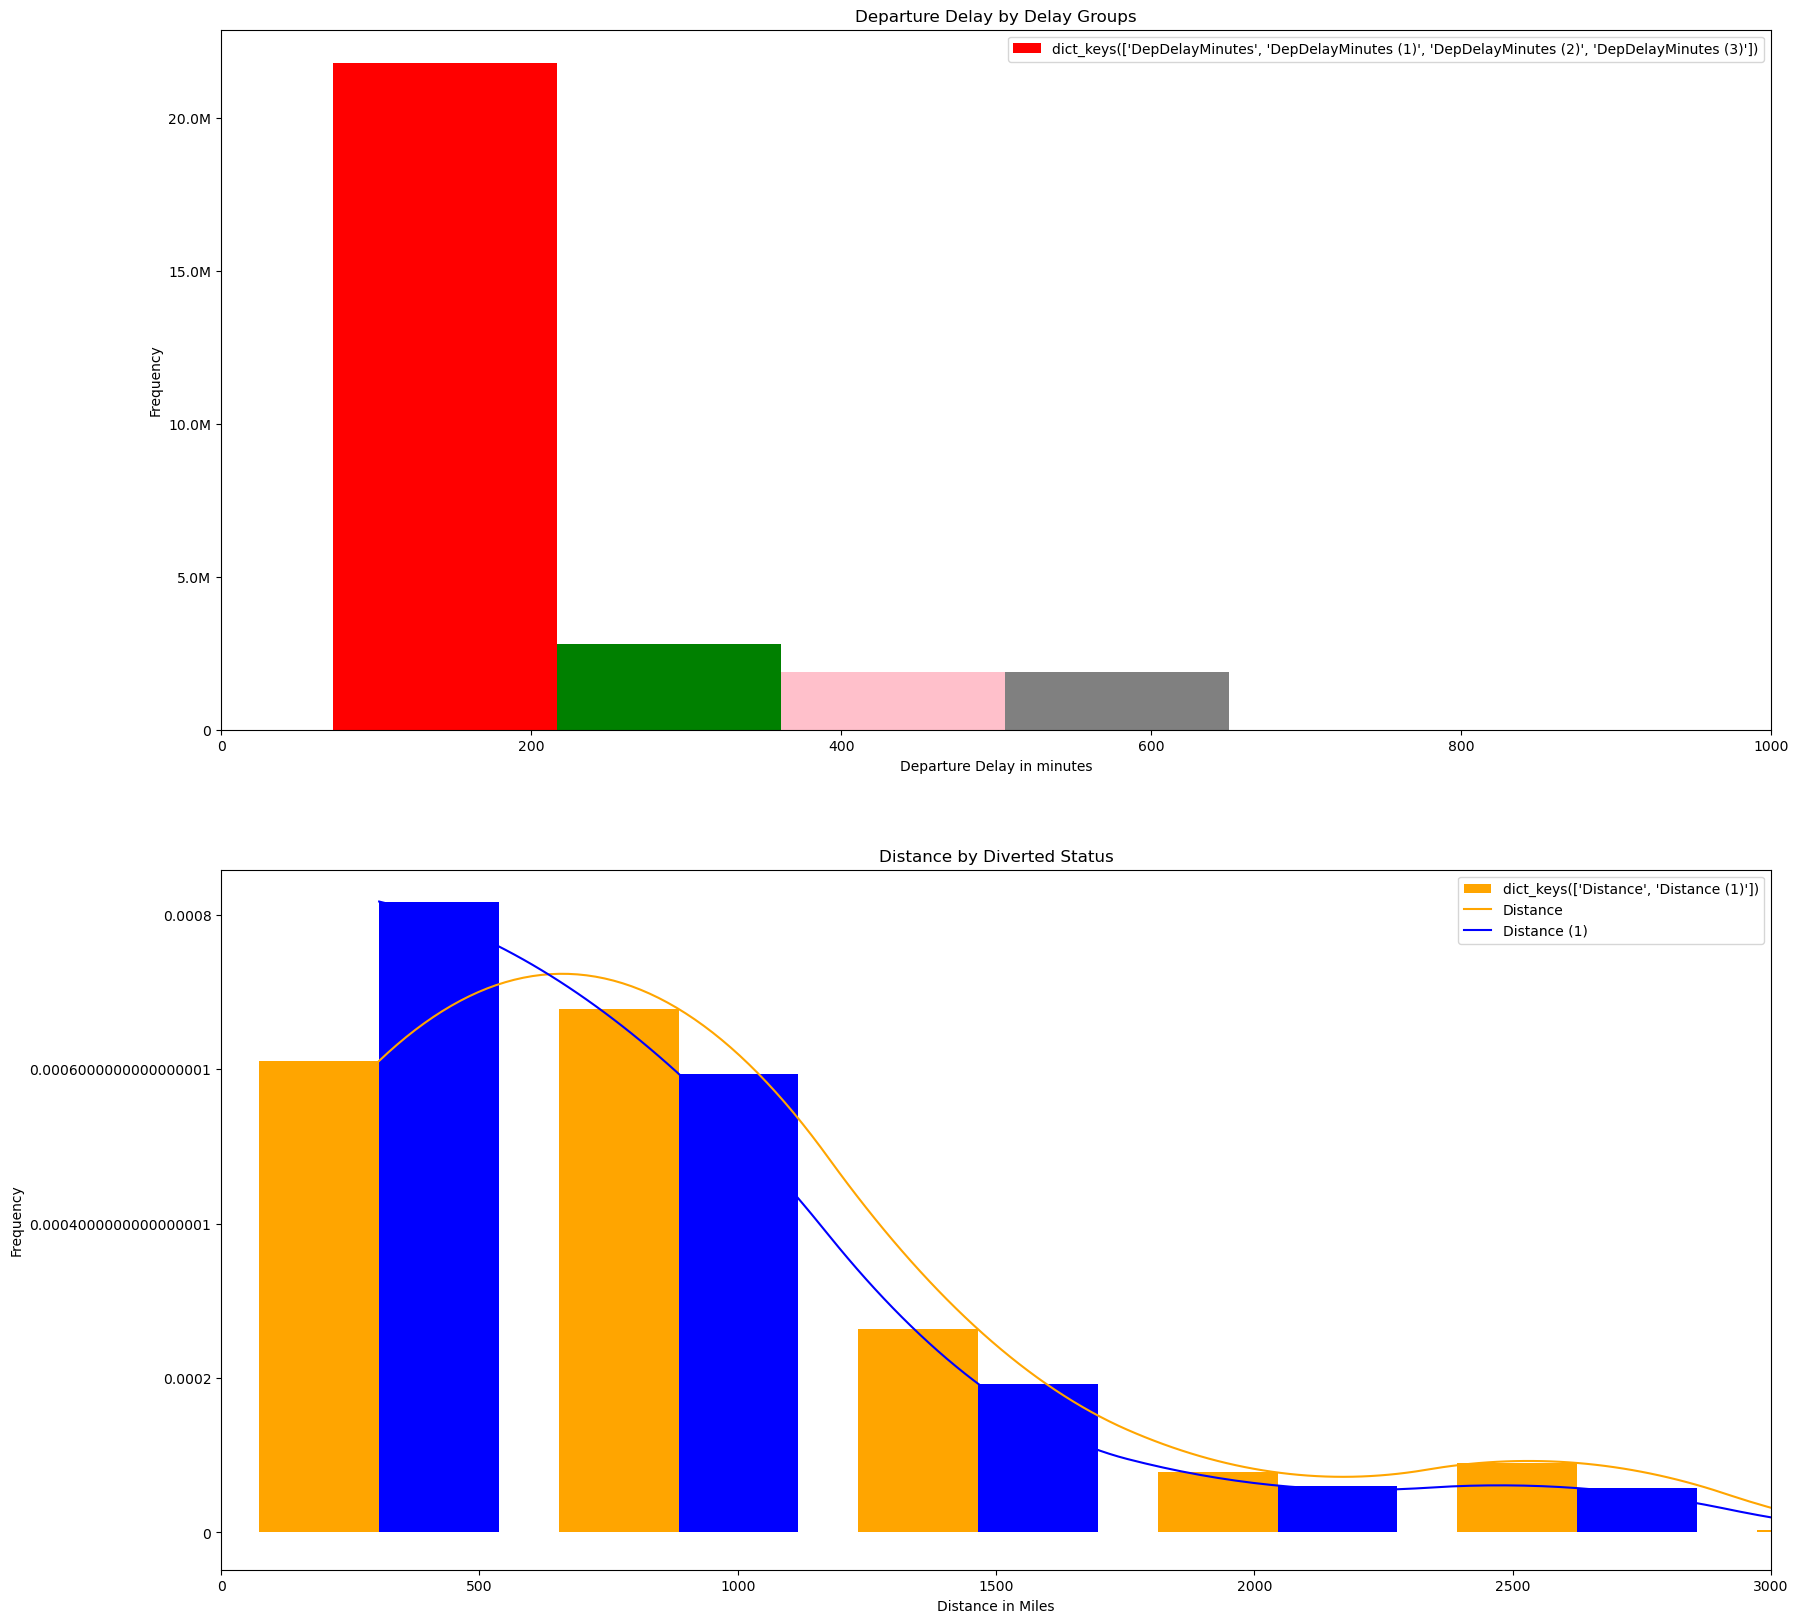

In [202]:
# filter data
on_time1 = df.filter(col("delay_group") == "On Time").select("DepDelayMinutes").alias("On Time")
small_delay = df.filter(col("delay_group") == "Small Delay").select("DepDelayMinutes").alias("Small Delay")
medium_delay = df.filter(col("delay_group") == "Medium Delay").select("DepDelayMinutes").alias("Medium Delay")
large_delay = df.filter(col("delay_group") == "Large Delay").select("DepDelayMinutes").alias("Large Delay")
diverted_y = df.filter(col("Diverted") == True).select("Distance").alias("diverted")
diverted_n = df.filter(col("Diverted") == False).select("Distance").alias("not diverted")

# plots
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_size_inches(20, 20)

# histogram
hist(ax[0], [on_time1, small_delay, medium_delay, large_delay], bins = 10, color = ['red', 'green', 'pink', 'grey'])
ax[0].set_title("Departure Delay by Delay Groups")
ax[0].set_xlabel('Departure Delay in minutes')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].set_xlim(xmin = 0, xmax = 1000)

# distplot
distplot(ax[1], [diverted_y, diverted_n], bins = 10, color = ['orange', 'blue'])
ax[1].set_title("Distance by Diverted Status")
ax[1].set_xlabel('Distance in Miles')
ax[1].set_ylabel('Frequency')
ax[1].legend()
ax[1].set_xlim(xmin = 0, xmax = 3000)